# Final Project Analysis

Changes to Analysis Plan: Added extension to question 3 to accompany another graph, and only selected top 5 most common job titles due to large number of unique job titles(doesn't scale well with ggplot). Q1 uses the pipeline and gridsearch method to determine the best penalty value for lasso. Q2 uses work_year instead of remote_ratio due to the latter having very little variation.

In [ ]:
# Import Necessary Packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN

from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline


In [ ]:
# Import Data
ds_sal = pd.read_csv("ds_salaries.csv")
ds_sal.head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


# Q1: Does the mean absolute error improve by much when applying LASSO on all predictors when comparing it to a model without applying it?

In [ ]:
# Check for missing values
ds_sal.isnull().sum()
# No missing values, so no cleanup needed.

# Create dummy variables for categorical variables
ds_sal_dums = pd.get_dummies(ds_sal, columns = ["experience_level", "employment_type", "job_title",
                                                "employee_residence", "company_location","company_size"])

ds_sal_dums.head()


,work_year,salary,salary_currency,salary_in_usd,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,...,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_L,company_size_M,company_size_S
0,2023,80000,EUR,85847,100,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,2023,30000,USD,30000,100,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
2,2023,25500,USD,25500,100,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,2023,175000,USD,175000,100,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,2023,120000,USD,120000,100,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Train MAE: 34148.25
Test MAE: 106167861948394.1 



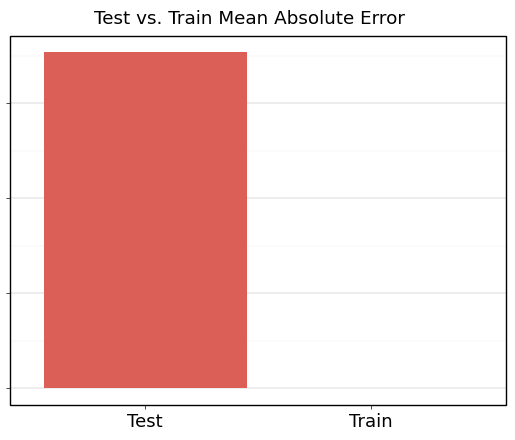

<ggplot: (8781912146152)>

In [ ]:
# Get predictors and outcome variable
predictors = ds_sal_dums.columns[4:259]

X = ds_sal_dums[predictors]
y = ds_sal_dums["salary_in_usd"]

# 80/20 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Z-score
z = StandardScaler()

X_train[["remote_ratio"]] = z.fit_transform(X_train[["remote_ratio"]])
X_test[["remote_ratio"]] = z.transform(X_test[["remote_ratio"]])

# Linear Regression Model
lr = LinearRegression()

lr.fit(X_train, y_train)

# Mean absolute error
mae_train = mean_absolute_error(y_train, lr.predict(X_train))
mae_test = mean_absolute_error(y_test, lr.predict(X_test))

mae_df = pd.DataFrame({"Group": ["Train", "Test"],
                       "MAE": [mae_train, mae_test]})

print("Train MAE:", np.round(mae_train, 2))
print("Test MAE:", np.round(mae_test, 2), "\n")

# Plot
(ggplot(mae_df, aes(x = "Group", y = "MAE", fill = "Group")) +
 stat_summary(geom = "bar") +
 labs(x = "", y = "", fill = "") +
 theme_linedraw() +
 ggtitle("Test vs. Train Mean Absolute Error") +
 theme(panel_grid_major_x = element_blank(),
       axis_text_x = element_text(size = 13),
       axis_text_y = element_blank(),
       legend_position = "none"))


Train MAE: 35821.77
Test MAE: 34648.11 



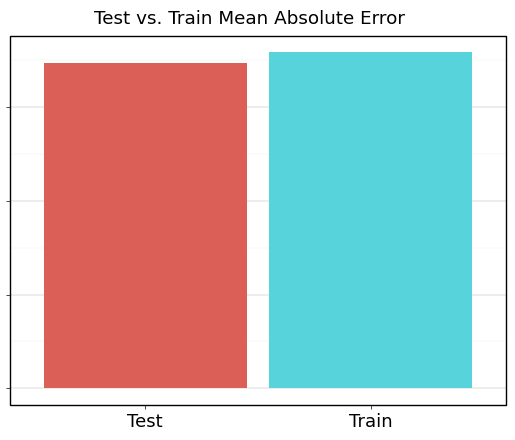

<ggplot: (8781903602899)>

In [ ]:
# Lasso
las = Lasso()

z = make_column_transformer((StandardScaler(), ["remote_ratio"]), remainder = "passthrough")
pipe = make_pipeline(z, las)

# Gridsearch for best alpha value
a = {"lasso__alpha": [25, 30, 35, 40, 45, 50]}

grid = GridSearchCV(pipe, a, scoring = "neg_mean_squared_error", cv = 5, refit = True)
grid.fit(X_train, y_train)

# Mean Absolute Error
mae_train = mean_absolute_error(y_train, grid.predict(X_train))
mae_test = mean_absolute_error(y_test, grid.predict(X_test))

mae_df = pd.DataFrame({"Group": ["Train", "Test"],
                       "MAE": [mae_train, mae_test]})

print("Train MAE:", np.round(mae_train, 2))
print("Test MAE:", np.round(mae_test, 2), "\n")

# Plot
(ggplot(mae_df, aes(x = "Group", y = "MAE", fill = "Group")) +
 stat_summary(geom = "bar") +
 labs(x = "", y = "", fill = "") +
 theme_linedraw() +
 ggtitle("Test vs. Train Mean Absolute Error") +
 theme(panel_grid_major_x = element_blank(),
       axis_text_x = element_text(size = 13),
       axis_text_y = element_blank(),
       legend_position = "none"))


Looking at the initial model, a linear regression model, the mean absolute error(MAE) for the training set was relatively high given the scale of the outcome variable. However, looking at the testing MAE showed a massive increase in the MAE indicating extreme overfitting and that too many varaibles are present. You can see this massive difference in the first graph above to the point where the train MAE isn't even visible. Applying LASSO in this instance proved to be really beneficial for model. The massive overfitting that occured initially is no longer present, and the two train and test MAE are much closer to eachother as displayed above in the second graph. While the MAE is still relatively high even with LASSO applied, applying it certainly improved the test MAE by a massive amount completely removing any signs of overfitting.

# Q2: Looking at work_year and salary(in USD), what type of clusters are formed and what kind of relationship is there between them?

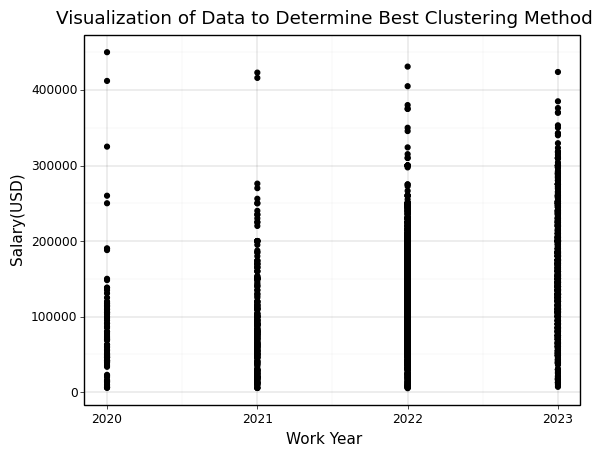

<ggplot: (8781912395876)>

In [ ]:
# Check for missing values
ds_sal.isnull().sum()
# No missing values, so no cleanup needed.

# Initial Plot
(ggplot(ds_sal, aes(x = "work_year", y = "salary_in_usd")) +
 geom_point() +
 theme_linedraw() +
 labs(x = "Work Year", y = "Salary(USD)", title = "Visualization of Data to Determine Best Clustering Method"))


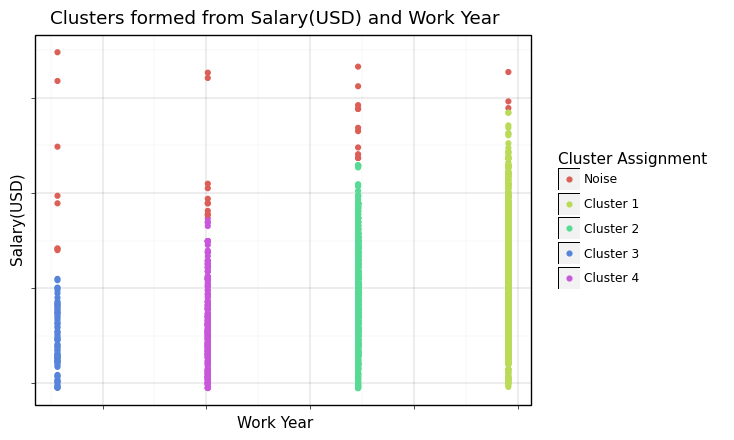

<ggplot: (8781913188359)>

In [ ]:
from plotnine.themes.themeable import axis_text_x

# Z-Score
vars = ["work_year", "salary_in_usd"]
V = ds_sal[vars]

z = StandardScaler()
V[vars] = z.fit_transform(V)

# Cluster
db = DBSCAN(eps = 0.5, min_samples = 20).fit(V)

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db.labels_)))]

V["assignments"] = db.labels_

# Plot
(ggplot(V, aes(x = "work_year", y = "salary_in_usd", color = "factor(assignments)")) +
 geom_point() +
 scale_color_discrete(name = "Cluster Assignment", labels = labsList) +
 labs(x = "Work Year", y = "Salary(USD)", title = "Clusters formed from Salary(USD) and Work Year") +
 theme_linedraw() +
 theme(axis_text_x = element_blank(), axis_text_y = element_blank()))


Looking at the second graph, you can see that very obvious clusters are generated from the work year and salary. While work year doesn't have lot of variation(the remote ratio didn't have much either, but work year was slightly better), a clear trend occurs. The noise or outliers, are more easily recognizable which gives a more generalized view of what the expected salary for a data science job could be. The overall trend displayed in the second graph shows that salaries in the data science field are generally growing at a linear rate. That growth rate also appears to be a moderately high amount too, indicating that data science based jobs are more in demand.

# Q3: Of the top 5 common job titles, based on the experience level, which jobs typically have a salary amount of greater than 100,000(in USD)? What kind of relationship is there? Is there a different relationship when basing it on company size?

In [ ]:
# Check for missing values
ds_sal.isnull().sum()
# No missing values, so no cleanup needed.

# Find top 5 most common job titles
print(pd.value_counts(ds_sal.job_title))

top5 = (ds_sal["job_title"] == "Data Engineer") | (ds_sal["job_title"] == "Data Scientist") | (ds_sal["job_title"] == "Data Analyst") | (ds_sal["job_title"] == "Machine Learning Engineer") | (ds_sal["job_title"] == "Analytics Engineer")


Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: job_title, Length: 93, dtype: int64


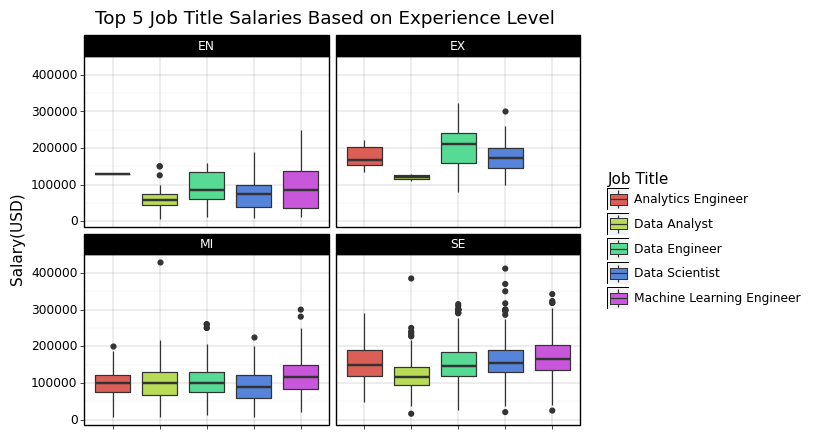

<ggplot: (8781912474249)>

In [ ]:
# Job titles salary amount, based on experience level
(ggplot(ds_sal.loc[top5], aes(x = "job_title", y = "salary_in_usd", fill = "job_title")) +
 geom_boxplot() +
 facet_wrap("~experience_level") +
 theme_linedraw() +
 labs(title = "Top 5 Job Title Salaries Based on Experience Level",
      x = "", y = "Salary(USD)") +
 theme(axis_text_x = element_blank()) +
 scale_fill_discrete(name = "Job Title"))


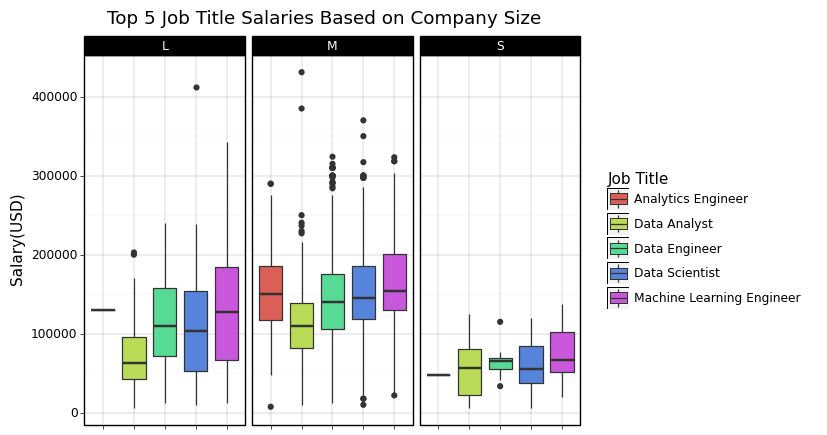

<ggplot: (8781903186929)>

In [ ]:
# Job titles salary amount, based on company size
(ggplot(ds_sal.loc[top5], aes(x = "job_title", y = "salary_in_usd", fill = "job_title")) +
 geom_boxplot() +
 facet_wrap("~company_size") +
 theme_linedraw() +
 labs(title = "Top 5 Job Title Salaries Based on Company Size",
      x = "", y = "Salary(USD)") +
 theme(axis_text_x = element_blank()) +
 scale_fill_discrete(name = "Job Title"))


From most common job title to least is Data Engineer, Data Scientist, Data Analyst, Machine Learning Engineer, and Analytics Engineer. When looking at the job title salaries and basing it off of experience level, all executive and senior level positions had an average salary above 100,000 dollars. Most mid-level positions were either just above 100,000 average salary or really close to it; the only job title that had an average below 100,000 is "Data Scientist". All entry level jobs, except analytics engineer, had an average salary below 100,000. Naturally the general relationship is that the higher the experience level the higher the salary. "Analytics Engineers" are consistently making above 100,000 across all experience levels. Mid-level jobs all have an average salarly roughy around 100,000. The job typically on the lower end of pay is "Data Analyst".

A somewhat similar relationship for certain job titles occurs when basing it on company size. "Analytics Engineer" typically stayed above 100,000 average salary with the exception of small companies. "Data Analyst" is again typically on the lower end of pay across all company sizes. Also "Machine Learning Engineer" typically has the widest range of salary. Interestingly, jobs at medium sized companies all have a higher average salary level when compared to large companies. This may be because medium sized companies want to attract talented individuals with higher pay, whereas larger companies can simply rely on their status to attract indivduals.

Overall though, most of these job titles will on average make over a 100,000 salary(in USD) at all experience levels except for the entry level(the only job with this exception is "Analytics Engineer"). If you base it on company size though, all jobs will have an average salary below 100,000 at small companies, but generally above that for medium and large companies(with the one exception of the "Data Analyst" job at large companies).

In [ ]:
# Create PDF
from google.colab import drive
drive.mount('/content/drive')

!cp "drive/My Drive/Colab Notebooks/Final Project-Erik Fryanov.ipynb" ./

!jupyter nbconvert --to PDF "Final Project-Erik Fryanov.ipynb"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook Final Project-Erik Fryanov.ipynb to PDF
[NbConvertApp] Support files will be in Final Project-Erik Fryanov_files/
[NbConvertApp] Making directory ./Final Project-Erik Fryanov_files
[NbConvertApp] Making directory ./Final Project-Erik Fryanov_files
[NbConvertApp] Making directory ./Final Project-Erik Fryanov_files
[NbConvertApp] Making directory ./Final Project-Erik Fryanov_files
[NbConvertApp] Making directory ./Final Project-Erik Fryanov_files
[NbConvertApp] Making directory ./Final Project-Erik Fryanov_files
[NbConvertApp] Writing 56120 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertAp